# Characterizing Datasets

TJ Kim <br/>
3/14/21

Updated <br/>
3/14/21

#### Objective: 
Characterize dataset that are not i.i.d distributed: <br/>

Deliverables
- Guassian extrapolation of mean and variance of each "feature node"
- PAC representation of the point clusters 

The different clusters will be divided along:
- nth data set for each client
- across class lines
- combination of 2 prior


In [1]:
cd '/home/ubuntu/FedAtk/' 

### Load Relevant Libraries and Modules

Load the relevant libraries for the federated learning code.

In [15]:
from transfer_attacks.DA_Transferer import *

import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import csv
import os
import pickle
from torch.autograd import Variable
import copy

### Load Model and data

In [4]:
# Make directory in results for this experiment
# FL Architecture
client_idx = 1
victim_idxs = [0,1,2,3]

# Saved Neural Networks to Test on 
exp_names = ["exp4_neck2_0_head3"]

# Parameters to record for excel printing
num_clients = len(victim_idxs)
metrics = ['orig_acc','orig_sim','orig_acc_robust', 'orig_sim_robust', 
           'orig_acc_adv', 'orig_sim_adv','adv_sim','adv_hit','g_align',
           'g_align_robust', 'g_align_adv']

In [5]:
transferer = DA_Transferer(filename = exp_names[0])
transferer.generate_advNN(client_idx = client_idx)
transferer.generate_victims(client_idxs = victim_idxs)
transferer.load_niid_data(clients=[0,1])

Loading  all_data_0_niid_0_keep_0_train_9.json
Loading  all_data_34_niid_0_keep_0_train_9.json
Loading  all_data_17_niid_0_keep_0_train_9.json
Loading  all_data_13_niid_0_keep_0_train_9.json
generated model


/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Plot PCA

First we plot for client case

In [39]:
transferer.set_data(mode='client', datasets = [0,1], batch_size = 200, classes = [0,1])
transferer.forward_pass()
transferer.obtain_PCA()

In [40]:
transferer.explained_var_ratio

array([0.10318697, 0.06662412])

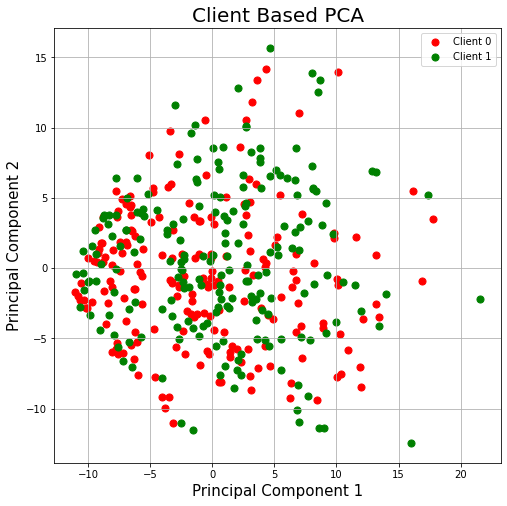

In [41]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Client Based PCA', fontsize = 20)


target_labels = ['Client 0', 'Client 1']
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = transferer.PCA_data['labels'] == target
    ax.scatter(transferer.PCA_data['data'][indicesToKeep,0]
               , transferer.PCA_data['data'][indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(target_labels)
ax.grid()

Then we plot the class case within one client.

In [42]:
transferer.set_data(mode='class', datasets = [0,1], batch_size = 200, classes = [0,1])
transferer.forward_pass()
transferer.obtain_PCA()

In [43]:
transferer.explained_var_ratio

array([0.19484695, 0.08150595])

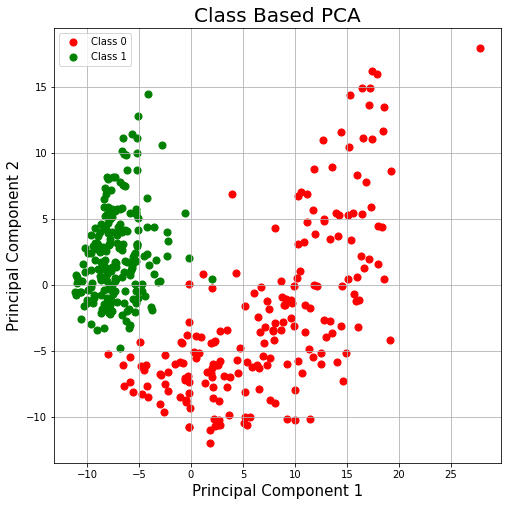

In [44]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Class Based PCA', fontsize = 20)


target_labels = ['Class 0', 'Class 1']
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = transferer.PCA_data['labels'] == target
    ax.scatter(transferer.PCA_data['data'][indicesToKeep,0]
               , transferer.PCA_data['data'][indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(target_labels)
ax.grid()

Then we plot the class-client pairs.

In [77]:
transferer.set_data(mode='both', datasets = [0,1], batch_size = 100, classes = [0,1])
transferer.forward_pass()
transferer.obtain_PCA()

In [78]:
transferer.explained_var_ratio

array([0.18755931, 0.08618463])

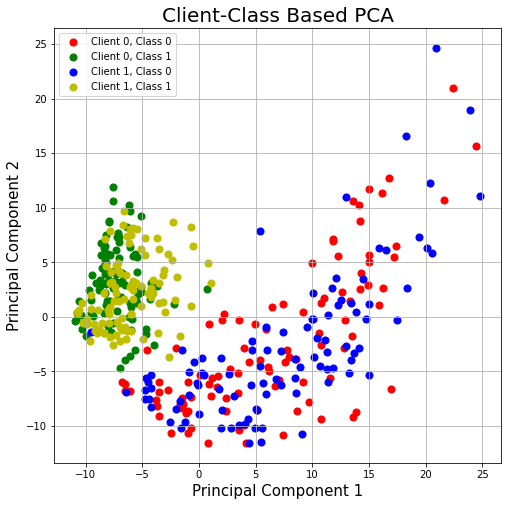

In [79]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Client-Class Based PCA', fontsize = 20)


target_labels = ['Client 0, Class 0','Client 0, Class 1','Client 1, Class 0','Client 1, Class 1']
targets = np.array([[0,0],[0,1],[1,0],[1,1]])
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    idx_temp0 = transferer.PCA_data['labels'][:,0] == target[0]
    idx_temp1 = transferer.PCA_data['labels'][:,1] == target[1]
    
    indicesToKeep = idx_temp0 * idx_temp1
    ax.scatter(transferer.PCA_data['data'][indicesToKeep,0]
               , transferer.PCA_data['data'][indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(target_labels)
ax.grid()